# Two-Layer Neural Networks

In this part of the homework, we will work on building a simple Neural Network to classify digits using MNIST dataset. There are many powerful neural network frameworks nowadays that are relatively straightforward to use. However, we believe that in order to understand the theory behind neural networks, and to have the right intuitions in order to build, use, and debug more complex architectures, one must first start from the basics.

Your task is to complete the missing codes needed for training and testing of a simple fully-connected neural network.

The missing parts will be marked with TODO#N, where N represents the task number.

Many parts in this homework are modified from Stanford's cs231n assignments.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# from cattern.neural_net import TwoLayerNet

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from __future__ import print_function


class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def ReLU(self,x):
    return np.maximum(0,x)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape
    # Compute the forward pass
    scores = None
    #############################################################################
    # TODO#1: Perform the forward pass, computing the class scores for the      #
    # input.                                                                    #
    # Store the result in the scores variable, which should be an array of      #
    # shape (N, C). Note that this does not include the softmax                 #
    # HINT: This is just a series of matrix multiplication.                     #
    #############################################################################
    
    tmp = self.ReLU(np.dot(X,W1) + b1)
    scores = np.dot(tmp,W2) + b2
    
    #############################################################################
    #                              END OF TODO#1                                #
    #############################################################################
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    #############################################################################
    # TODO#2: Finish the forward pass, and compute the loss. This should include#
    # both the data loss and L2 regularization for W1 and W2. Store the result  #
    # in the variable loss, which should be a scalar. Use the Softmax           #
    # classifier loss.                                                          #
    #############################################################################
    
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    ylogprobs = -np.log(probs[range(N), y])
    loss = np.sum(ylogprobs) / N
    reg_loss = 0.5 * reg * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
    loss = loss + reg_loss
    
    #############################################################################
    #                              END OF TODO#2                                #
    #############################################################################

    # Backward pass: compute gradients
    grads = {}
    #############################################################################
    # TODO#3: Compute the backward pass, computing derivatives of the weights   #
    # and biases. Store the results in the grads dictionary. For example,       #
    # grads['W1'] should store the gradient on W1, and be a matrix of same size #
    # don't forget about the regularization term                                #
    #############################################################################
    
    dscores = probs.copy()
    dscores[range(N), y] -= 1
    dscores /= N

    grads['W2'] = self.ReLU(X.dot(W1) + b1).T.dot(dscores)
    grads['b2'] = np.sum(dscores, axis=0)
    grads['W2'] += reg * W2

    dhidden = dscores.dot(W2.T)
    dhidden[self.ReLU(X.dot(W1) + b1) <= 0] = 0

    grads['W1'] = X.T.dot(dhidden)
    grads['b1'] = np.sum(dhidden, axis=0)
    grads['W1'] += reg * W1
    
    #############################################################################
    #                              END OF TODO#3                                #
    #############################################################################

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=2000,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)
    epoch = 1
    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO#4: Create a random minibatch of training data and labels, storing#
      # them in X_batch and y_batch respectively.                             #
      # You might find np.random.choice() helpful.                            #
      #########################################################################
      seed = np.random.choice(num_train, batch_size, replace=True)
      X_batch = X[seed]
      y_batch = y[seed]
      #########################################################################
      #                             END OF YOUR TODO#4                        #
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      #########################################################################
      # TODO#5: Use the gradients in the grads dictionary to update the       #
      # parameters of the network (stored in the dictionary self.params)      #
      # using stochastic gradient descent. You'll need to use the gradients   #
      # stored in the grads dictionary defined above.                         #
      #########################################################################
      self.params["W1"] -= learning_rate * grads["W1"]
      self.params["b1"] -= learning_rate * grads["b1"]
      self.params["W2"] -= learning_rate * grads["W2"]
      self.params["b2"] -= learning_rate * grads["b2"]
      #########################################################################
      #                             END OF YOUR TODO#5                        #
      #########################################################################
      
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        #######################################################################
        # TODO#6: Decay learning rate (exponentially) after each epoch        #
        #######################################################################
        
        learning_rate *= learning_rate_decay
        # learning_rate *= np.exp(-learning_rate_decay * epoch)
        # epoch+=1
        
        #######################################################################
        #                             END OF YOUR TODO#6                      #
        #######################################################################
        

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None

    ###########################################################################
    # TODO#7: Implement this function; it should be VERY simple!              #
    ###########################################################################
    
    tmp = self.ReLU(X.dot(self.params["W1"]) + self.params["b1"])
    scores = tmp.dot(self.params["W2"]) + self.params["b2"]
    y_pred = np.argmax(scores, axis=1)

    ###########################################################################
    #                              END OF YOUR TODO#7                         #
    ###########################################################################

    return y_pred

In [21]:
# Just a function that verifies if your answers are correct

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cattern/neural_net.py` to represent instances of our network. The network parameters (weights and biases) are stored in the instance variable `self.params` where the keys are parameter names and values are numpy arrays. Below, we initialize some toy data and a toy model that will guide you with your implementation.

In [22]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cattern/neural_net.py` and look at the method `TwoLayerNet.loss`. This function takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Complete TODO#1 in `TwoLayerNet.loss`, by implementing the first part of the forward pass which uses the weights and biases to compute the scores for all inputs. The scores refer to the output of the network just before the softmax layer.

In [23]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720496109664e-08


# Forward pass: compute loss
In the same function, complete TODO#2 by implementing the second part that computes the data and regularizaion loss.

In [24]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))
print(loss, correct_loss)

Difference between your loss and correct loss:
1.794120407794253e-13
1.3037878913298206 1.30378789133


# Backward pass
Implement the rest of the function by completing TODO#3. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [25]:
from cattern.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 3.865028e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738422e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD). Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure (TODO#4-6). You will also have to implement `TwoLayerNet.predict` (TODO#7), as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.05.

Final training loss:  0.015531052322646665


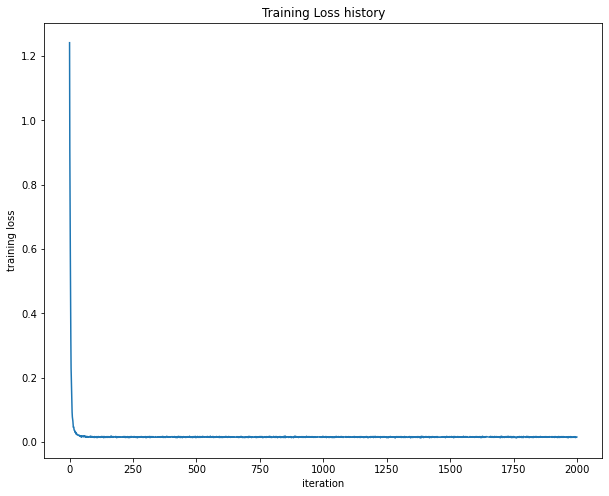

In [26]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=2000, verbose=False)
print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up MNIST data so we can use it to train a classifier on a real dataset.

In [27]:
from mnist_data import load_mnist


def get_mnist_data(num_training=55000, num_validation=5000, num_test=10000):
    """
    Load the MNIST dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw MNIST data
    X_train, y_train, X_val, y_val, X_test, y_test = load_mnist.read_data_sets('mnist_data')

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train = X_train - mean_image
    X_val = X_val - mean_image
    X_test = X_test - mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_mnist_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Train data shape:  (55000, 784)
Train labels shape:  (55000,)
Validation data shape:  (5000, 784)
Validation labels shape:  (5000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


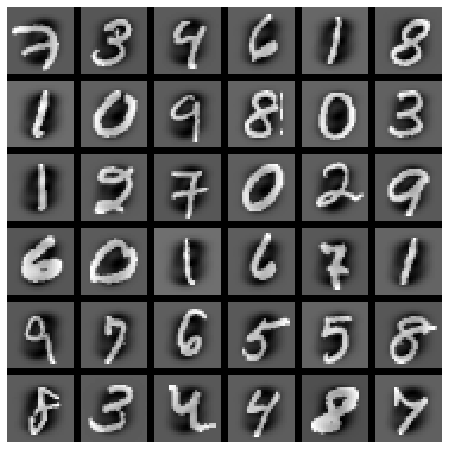

In [28]:
from mnist_data.vis_utils import visualize_grid

# Visualize mnist data

def show_mnist_image(data):
  data = data.reshape(-1, 28, 28, 1)
  plt.imshow(visualize_grid(data, padding=3).astype('uint8').squeeze(axis=2))
  plt.gca().axis('off')
  plt.show()

show_mnist_image(X_train[:36])

# Train a network
To train our network we will use SGD with momentum. We will use fixed learning rate to train this model.

In [29]:
input_size = 28 * 28 * 1
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=1,
            reg=0, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 2000: loss 2.302590
iteration 100 / 2000: loss 2.302330
iteration 200 / 2000: loss 2.301000
iteration 300 / 2000: loss 2.293358
iteration 400 / 2000: loss 2.234620
iteration 500 / 2000: loss 2.024081
iteration 600 / 2000: loss 1.744045
iteration 700 / 2000: loss 1.518284
iteration 800 / 2000: loss 1.130942
iteration 900 / 2000: loss 0.893439
iteration 1000 / 2000: loss 0.841629
iteration 1100 / 2000: loss 0.724354
iteration 1200 / 2000: loss 0.537807
iteration 1300 / 2000: loss 0.563390
iteration 1400 / 2000: loss 0.491234
iteration 1500 / 2000: loss 0.439629
iteration 1600 / 2000: loss 0.424721
iteration 1700 / 2000: loss 0.443073
iteration 1800 / 2000: loss 0.460611
iteration 1900 / 2000: loss 0.366162
Validation accuracy:  0.8998


In [30]:
stats.keys()

dict_keys(['loss_history', 'train_acc_history', 'val_acc_history'])

# Learning Rate Decay

In the previous run, we used the same learning rate during the whole training process. This fix-sized learning rate disregards the benefit of larger learning rate at the beginning of the training, and it might suffer from overshooting around the minima.

Add learning rate decay to the train function, run the model again with larger starting learning rate and learning rate decay, then compare the losses.

In [31]:
net = TwoLayerNet(input_size, hidden_size, num_classes)
stats_LRDecay = net.train(X_train, y_train, X_val, y_val,
                    num_iters=2000, batch_size=200,
                    learning_rate=5e-4, learning_rate_decay=0.95,
                    reg=0, verbose=True)

# Predict on the validation set
val_acc_LRDecay = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc_LRDecay)

iteration 0 / 2000: loss 2.302581
iteration 100 / 2000: loss 2.146031
iteration 200 / 2000: loss 0.826060
iteration 300 / 2000: loss 0.510849
iteration 400 / 2000: loss 0.402777
iteration 500 / 2000: loss 0.387165
iteration 600 / 2000: loss 0.319708
iteration 700 / 2000: loss 0.233548
iteration 800 / 2000: loss 0.342961
iteration 900 / 2000: loss 0.280628
iteration 1000 / 2000: loss 0.201636
iteration 1100 / 2000: loss 0.255988
iteration 1200 / 2000: loss 0.270569
iteration 1300 / 2000: loss 0.230643
iteration 1400 / 2000: loss 0.278824
iteration 1500 / 2000: loss 0.213527
iteration 1600 / 2000: loss 0.211418
iteration 1700 / 2000: loss 0.306729
iteration 1800 / 2000: loss 0.153764
iteration 1900 / 2000: loss 0.233236
Validation accuracy:  0.9446


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.94 on the validation set. This isn't very good for MNIST data which has reports of up to 0.99 accuracy.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized. 

(You can think of the first layer weights as a projection W^TX. This is very similar to how we project our training data using PCA projection in our previous homework. Just like how we visualize the eigenfaces. We can also visualize the weights of the neural network in the same manner.)

Below, we will also show you lossed between two models we trained above. Do you notice the difference between the two?

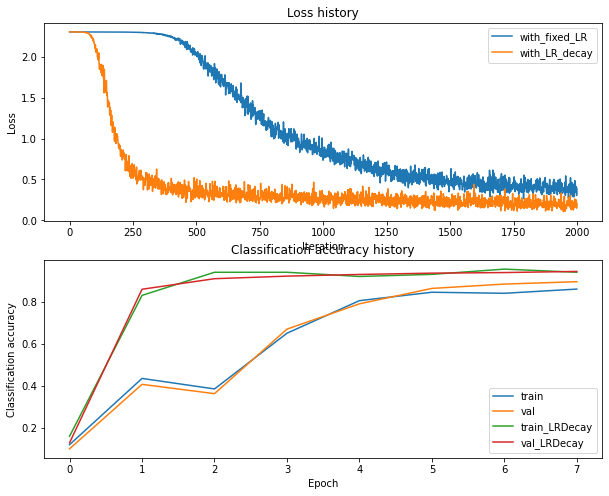

In [32]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'], label='with_fixed_LR')
plt.plot(stats_LRDecay['loss_history'], label='with_LR_decay')
plt.title('Loss history')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.plot(stats_LRDecay['train_acc_history'], label='train_LRDecay')
plt.plot(stats_LRDecay['val_acc_history'], label='val_LRDecay')
plt.title('Classification accuracy history')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.show()

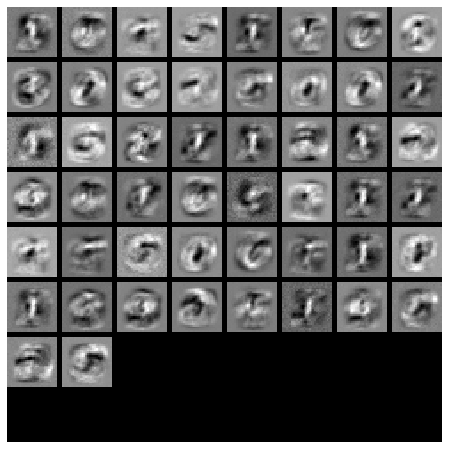

In [33]:
# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(28, 28, 1, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8').squeeze(axis=2))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 97.4% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on MNIST as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [34]:
best_net = None # store the best model into this 

#################################################################################
# TODO#8: Tune hyperparameters using the validation set. Store your best trained#
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

input_size = 28 * 28 * 1
hidden_size = 128
num_classes = 10


best_net = TwoLayerNet(input_size, hidden_size, num_classes)
stats_LRDecay = best_net.train(X_train, y_train, X_val, y_val,
                    num_iters=1500, batch_size=200,
                    learning_rate=1e-2, learning_rate_decay=0.95,
                    reg=5e-6, verbose=True)

# Predict on the validation set
val_acc_LRDecay = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc_LRDecay)
#################################################################################
#                               END OF TODO#8                                   #
#################################################################################

iteration 0 / 1500: loss 2.302549
iteration 100 / 1500: loss 0.264106
iteration 200 / 1500: loss 0.176508
iteration 300 / 1500: loss 0.082832
iteration 400 / 1500: loss 0.120134
iteration 500 / 1500: loss 0.083791
iteration 600 / 1500: loss 0.128019
iteration 700 / 1500: loss 0.049757
iteration 800 / 1500: loss 0.038699
iteration 900 / 1500: loss 0.118471
iteration 1000 / 1500: loss 0.068591
iteration 1100 / 1500: loss 0.042772
iteration 1200 / 1500: loss 0.016592
iteration 1300 / 1500: loss 0.018214
iteration 1400 / 1500: loss 0.035817
Validation accuracy:  0.9748


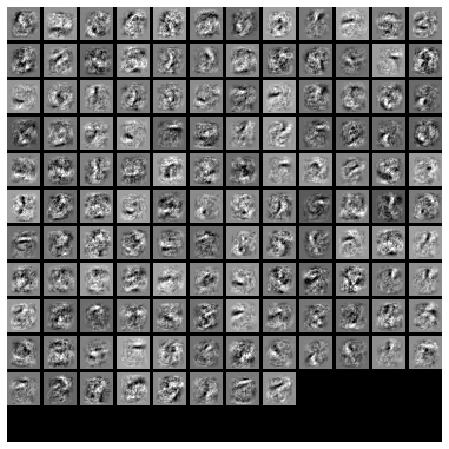

In [35]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 96.3%.

In [36]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.9762
